In [1]:
library(dplyr)
library(tidyverse)
library(data.table)
library(ebpmf)
library(NNLM)
library(Matrix)
library(CountClust)
library(fastTopics)
library(FNN)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.4.1     v purrr   0.3.4
v tibble  3.1.8     v stringr 1.4.0
v tidyr   1.2.0     v forcats 0.5.1
v readr   2.1.2     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'data.table'


The following object is masked from 'package:purrr':

    transpose


The following objects are masked from 'package:dplyr':

    between, first, last



Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack




In [2]:

plot_structure <- function(fit, gene_name, kfactors){
    EL = fit$EL
    indis = rownames(EL)
    tissue_label  <- c()
    for (x in rownames(EL)){
        tissue_label <- c(tissue_label, strsplit(x, '[.]')[[1]][1])
    }
    annotation_ = data.frame(sample_id = indis,tissue_label = tissue_label)
    print(head(annotation_))
    
    
    colnames(EL) <- sprintf("factor%d",seq(1:kfactors))
    colores = RColorBrewer::brewer.pal(kfactors,  "Paired")
    
   StructureGGplot(EL, annotation = annotation_,
                      palette = colores, figure_title = gene_name,
                      axis_tick = list(axis_ticks_length = 0.1, 
                                       axis_ticks_lwd_y = 1, 
                                       axis_ticks_lwd_x = 1, 
                                       axis_label_size = 12, axis_label_face = "bold"),
                         legend_title_size = 12, legend_key_size = 1, legend_text_size = 12)
}

In [23]:
dir <- '/project2/mstephens/cfbuenabadn/'
ebpmf_dir <- paste0(dir, 'gtex-stm/code/ebpmf_model/train_2tissues/')

# gtex-stm/code/Counts/

annotation = read.table(paste0(dir, 'gtex-stm/code/config/samples.tsv'), sep='\t', header=1, row.names=1)

srsf3 = readRDS(paste0(ebpmf_dir, 'Brain_Cortex.Muscle_Skeletal-TPM3.K2.ebpmf.rds'))

                              sample_id tissue_label
1 Brain_Cortex.GTEX-11GSP-3226-SM-5986O Brain_Cortex
2 Brain_Cortex.GTEX-11TTK-2926-SM-5PNYP Brain_Cortex
3 Brain_Cortex.GTEX-12WSD-3126-SM-5HL7P Brain_Cortex
4 Brain_Cortex.GTEX-12ZZX-2926-SM-5GCOQ Brain_Cortex
5 Brain_Cortex.GTEX-1313W-3126-SM-5LZUI Brain_Cortex
6 Brain_Cortex.GTEX-131XW-3126-SM-5LZUC Brain_Cortex


Warning message in RColorBrewer::brewer.pal(kfactors, "Paired"):
"minimal value for n is 3, returning requested palette with 3 different levels
"
Warning message:
"Use of `df_mlt$document` is discouraged.
i Use `document` instead."
Warning message:
"Use of `df_mlt$value` is discouraged.
i Use `value` instead."
Warning message:
"Use of `df_mlt$topic` is discouraged.
i Use `topic` instead."


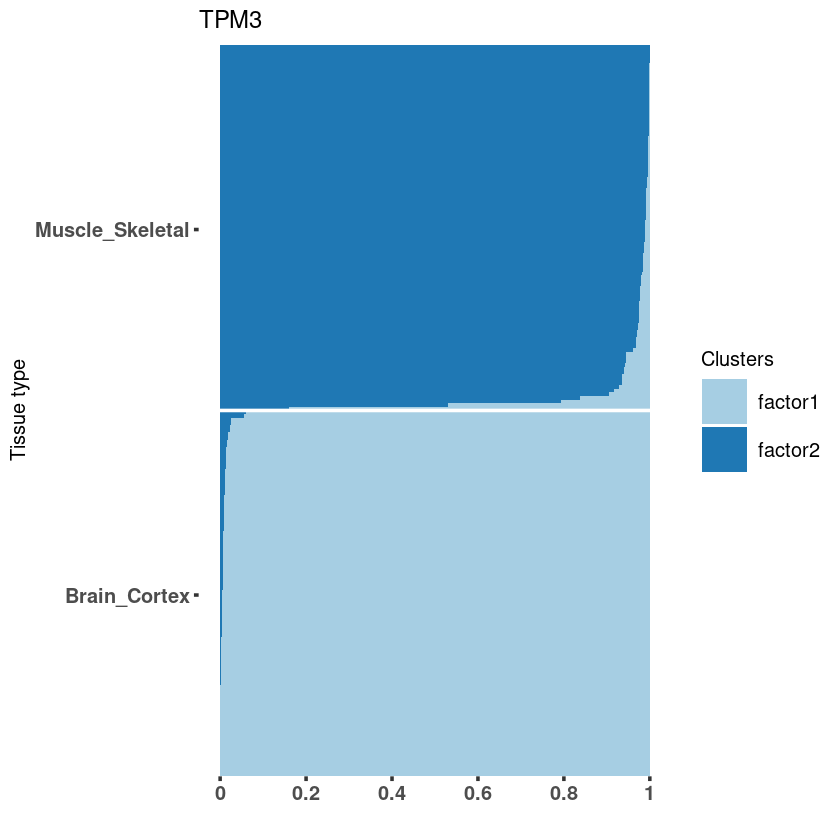

In [24]:
plot_structure(srsf3$fit_ebpmf, 'TPM3', 2)

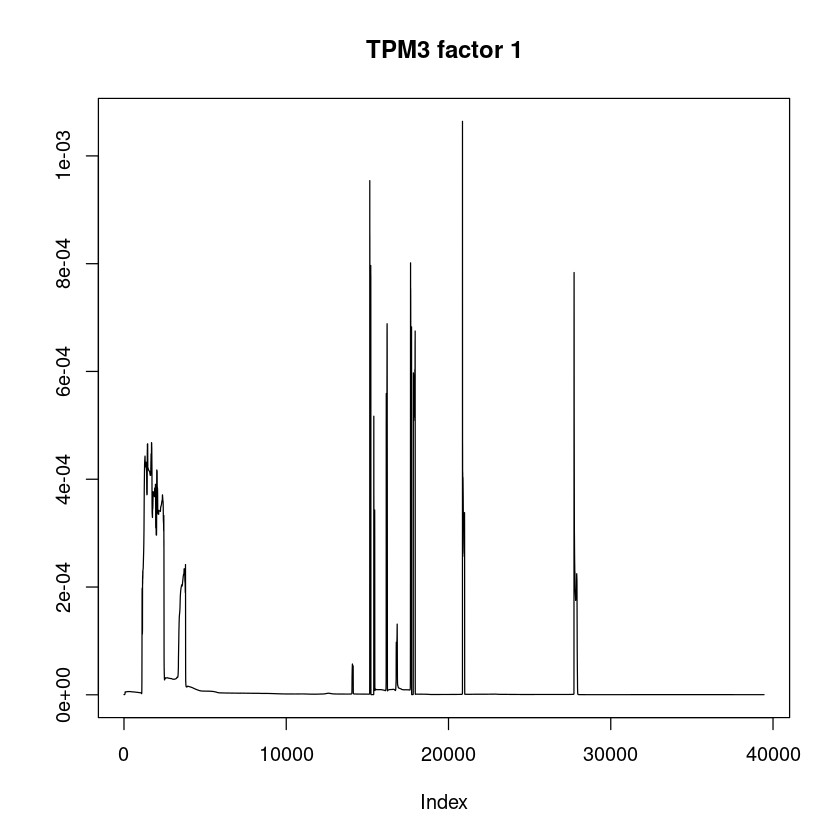

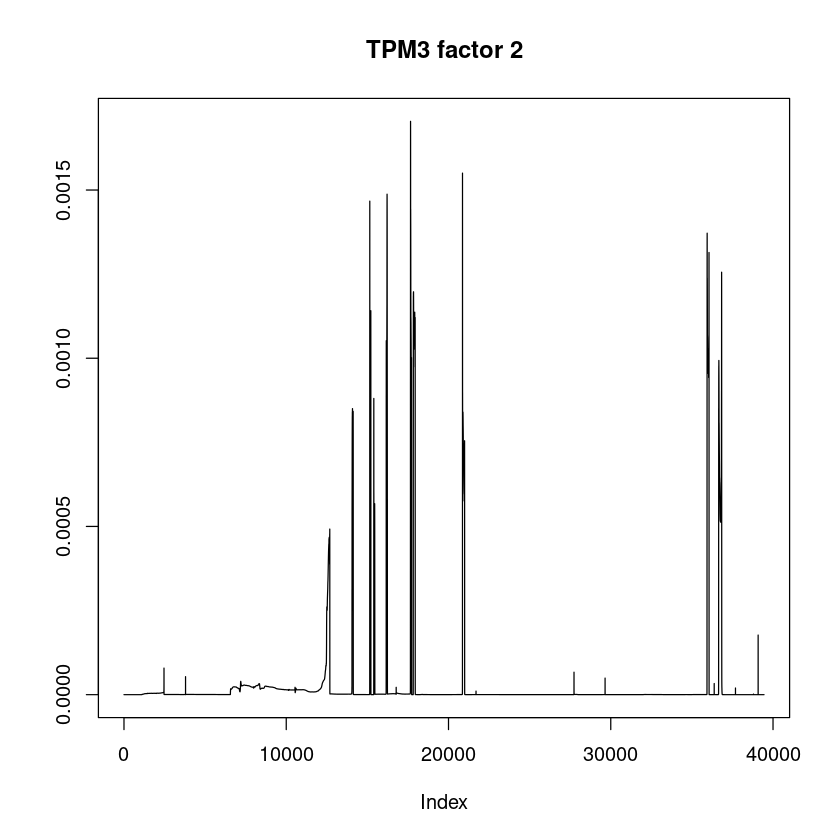

In [96]:
plot(srsf3$fit_ebpmf$EF[,1],type='l',ylab='',main='TPM3 factor 1')
plot(srsf3$fit_ebpmf$EF[,2],type='l',ylab='',main='TPM3 factor 2')


In [6]:
# args = commandArgs(trailingOnly=TRUE)
# tissue_list = args[1]
# geneName = args[2]
# K = as.integer(args[3])
# output = args[4]

tissue_list <- c('Brain_Cortex', 'Muscle_Skeletal')

dir <- '/project2/mstephens/cfbuenabadn/gtex-stm/code/'

samples <- read.table(paste0(dir, 'config/samples.tsv'))

X <- data.frame()

for (tissue in tissue_list){
    train_samples <- samples %>%
                  filter(tissue_id == tissue, group == 'male_test') %>%
                  rownames() %>%
                  paste0(tissue, ".", .)
    tissue_counts <- read.csv(paste0(dir, 'Counts/', tissue, '/TPM3.Counts.csv.gz'),
                           row.names = 1, header=TRUE) %>% filter(rownames(.) %in% train_samples)
    X <- rbind(X, tissue_counts)
    }

X <- X %>% as.matrix()

# fit_ebpmf = ebpmf_identity(X,K=K)


In [16]:
EL <- srsf3$fit_ebpmf$EL

brain <- EL %>% as.data.frame() %>% filter(startsWith(rownames(.), "Brain_Cortex"))
muscle <- EL %>% as.data.frame() %>% filter(startsWith(rownames(.), "Muscle_Skeletal"))
KL.divergence(brain[,'k2'], muscle[,'k2'], 1)

[1] 8.869662

In [8]:
FF <- as.matrix(srsf3$fit_ebpmf$EF)
fit_init = init_poisson_nmf(X, F = FF, init.method = 'random')
out = fit_poisson_nmf(X,fit0=fit_init,update.factors = NULL)

Using 8 RcppParallel threads.



Fitting rank-2 Poisson NMF to 6 x 39444 dense matrix.
Running 100 SCD updates, without extrapolation (fastTopics 0.6-97).



[=====>-----------------------------------------------------------------]   8%

[=====>-----------------------------------------------------------------]   9%

[======>----------------------------------------------------------------]  10%

[=======>---------------------------------------------------------------]  11%

[========>--------------------------------------------------------------]  12%

[========>--------------------------------------------------------------]  13%

[=========>-------------------------------------------------------------]  14%

[==========>------------------------------------------------------------]  15%

[==========>------------------------------------------------------------]  16%

[===========>-----------------------------------------------------------]  17%

[============>----------------------------------------------------------]  18%

[============>----------------------------------------------------------]  19%

[=============>------------------------

In [9]:
out$L/rowSums(out$L)

,k1,k2
Brain_Cortex.GTEX-145MG-3026-SM-5RQJA,0.99967312,0.0003268823
Brain_Cortex.GTEX-145MH-3026-SM-5Q5DZ,0.99777510,0.0022248998
Brain_Cortex.GTEX-147GR-3026-SM-5S2ML,0.99935179,0.0006482094
Muscle_Skeletal.GTEX-12ZZY-0626-SM-5EQ5T,0.02075179,0.9792482142
Muscle_Skeletal.GTEX-12ZZZ-0226-SM-59HKU,0.04624686,0.9537531424
Muscle_Skeletal.GTEX-13111-2226-SM-5LZUE,0.02222011,0.9777798927


In [10]:
out_ratio <- data.frame(row.names = rownames(out$L))
out_ratio['k1'] <- out$L[,'k1']/(out$L[,'k1'] + out$L[,'k2'])
out_ratio['k2'] <- out$L[,'k2']/(out$L[,'k1'] + out$L[,'k2'])
rownames(out_ratio) <- rownames(out$L)

brain <- out_ratio %>% as.data.frame() %>% filter(startsWith(rownames(.), "Brain_Cortex"))
muscle <- out_ratio %>% as.data.frame() %>% filter(startsWith(rownames(.), "Muscle_Skeletal"))

In [11]:
library(FNN)

In [13]:
brain

,k1,k2
,<dbl>,<dbl>
Brain_Cortex.GTEX-145MG-3026-SM-5RQJA,0.9996731,0.0003268823
Brain_Cortex.GTEX-145MH-3026-SM-5Q5DZ,0.9977751,0.0022248998
Brain_Cortex.GTEX-147GR-3026-SM-5S2ML,0.9993518,0.0006482094


In [14]:
muscle

,k1,k2
,<dbl>,<dbl>
Muscle_Skeletal.GTEX-12ZZY-0626-SM-5EQ5T,0.02075179,0.9792482
Muscle_Skeletal.GTEX-12ZZZ-0226-SM-59HKU,0.04624686,0.9537531
Muscle_Skeletal.GTEX-13111-2226-SM-5LZUE,0.02222011,0.9777799


In [15]:
KL.divergence(brain[,'k2'], muscle[,'k2'], 1)

[1] 7.464373

In [49]:
tissue_list <- c('Brain_Cortex', 'Muscle_Skeletal')

dir <- '/project2/mstephens/cfbuenabadn/gtex-stm/code/'

samples <- read.table(paste0(dir, 'config/samples.tsv'))

X <- data.frame()

tissue <- 'Brain_Cortex'

for (test in c('male_test', 'male_test2')){
    train_samples <- samples %>%
                  filter(tissue_id == 'Brain_Cortex', group == test) %>%
                  rownames() %>%
                  paste0(tissue, ".", .)
    tissue_counts <- read.csv(paste0(dir, 'Counts/', tissue, '/TPM3.Counts.csv.gz'),
                           row.names = 1, header=TRUE) %>% filter(rownames(.) %in% train_samples)
    X <- rbind(X, tissue_counts)
    }

X <- X %>% as.matrix()

# fit_ebpmf = ebpmf_identity(X,K=K)


In [51]:
FF <- as.matrix(srsf3$fit_ebpmf$EF)
fit_init = init_poisson_nmf(X, F = FF, init.method = 'random')
out = fit_poisson_nmf(X,fit0=fit_init,update.factors = NULL)

Input matrix "X" has less than 10% nonzero entries; consider converting "X" to a sparse matrix to reduce computational effort

Using 8 RcppParallel threads.



Fitting rank-2 Poisson NMF to 6 x 39444 dense matrix.
Running 100 SCD updates, without extrapolation (fastTopics 0.6-97).



[======>----------------------------------------------------------------]  10%

[=======>---------------------------------------------------------------]  11%

[========>--------------------------------------------------------------]  12%

[========>--------------------------------------------------------------]  13%

[=========>-------------------------------------------------------------]  14%

[==========>------------------------------------------------------------]  15%

[==========>------------------------------------------------------------]  16%

[===========>-----------------------------------------------------------]  17%

[============>----------------------------------------------------------]  18%

[============>----------------------------------------------------------]  19%

[=============>---------------------------------------------------------]  20%

[==============>--------------------------------------------------------]  21%

[===============>----------------------

In [50]:
head(t(X))

,Brain_Cortex.GTEX-145MG-3026-SM-5RQJA,Brain_Cortex.GTEX-145MH-3026-SM-5Q5DZ,Brain_Cortex.GTEX-147GR-3026-SM-5S2ML,Brain_Cortex.GTEX-14ASI-3026-SM-5S2PN,Brain_Cortex.GTEX-14BIL-3026-SM-7EWD4,Brain_Cortex.GTEX-14BMV-3026-SM-5S2PQ
chr1.154155254,0,0,0,0,0,0
chr1.154155255,0,0,0,0,0,0
chr1.154155256,0,0,0,0,0,0
chr1.154155257,0,0,0,0,0,0
chr1.154155258,0,0,0,0,0,0
chr1.154155259,0,0,0,0,0,0


In [37]:
tissue_counts <- read.csv(paste0(dir, 'Counts/', tissue, '/TPM3.Counts.csv.gz'),
                           row.names = 1, header=TRUE) #%>% filter(rownames(.) %in% train_samples)

In [93]:
tissue_list <- c('Brain_Cortex', 'Muscle_Skeletal')

dir <- '/project2/mstephens/cfbuenabadn/gtex-stm/code/'

tissue <- 'Brain_Cortex'

samples <- read.table(paste0(dir, 'config/samples.tsv'))
male_test_samples <- samples %>%
                  filter(tissue_id == 'Brain_Cortex', group == 'male_test') %>%
                  rownames() %>%
                  paste0(tissue, ".", .)

male_test2_samples <- samples %>%
                  filter(tissue_id == 'Brain_Cortex', group == 'female_test') %>%
                  rownames() %>%
                  paste0(tissue, ".", .)

In [94]:
male_test2_samples

[1] "Brain_Cortex.GTEX-1117F-3226-SM-5N9CT"
[2] "Brain_Cortex.GTEX-1128S-2726-SM-5H12C"
[3] "Brain_Cortex.GTEX-11EMC-3226-SM-5EGKW"

In [87]:
male_test2_samples

[1] "Brain_Cortex.GTEX-1117F-3226-SM-5N9CT"
[2] "Brain_Cortex.GTEX-1128S-2726-SM-5H12C"
[3] "Brain_Cortex.GTEX-11EMC-3226-SM-5EGKW"

In [88]:
out_ratio <- data.frame(row.names = rownames(out$L))
out_ratio['k1'] <- out$L[,'k1']/(out$L[,'k1'] + out$L[,'k2'])
out_ratio['k2'] <- out$L[,'k2']/(out$L[,'k1'] + out$L[,'k2'])
rownames(out_ratio) <- rownames(out$L)

brain1 <- out_ratio %>% as.data.frame() %>% filter(rownames(.) %in% male_test_samples)
brain2 <- out_ratio %>% as.data.frame() %>% filter(rownames(.) %in% male_test2_samples)

In [89]:
brain1[,'k1'], brain2[,'k1']

ERROR: Error in parse(text = x, srcfile = src): <text>:1:14: unexpected ','
1: brain1[,'k1'],
                 ^


In [90]:
KL.divergence(brain1[,'k1'], brain2[,'k1'], 1)

Warning message in get.knnx(data, query, k, algorithm):
"k should be less than sample size!"


ERROR: Error in get.knnx(data, query, k, algorithm): ANN: ERROR------->


In [91]:
dim(brain2)

[1] 0 2

In [66]:
t_male_test <- t.test(brain1[,'k1'], brain2[,'k1'])

In [68]:
t_male_test


	Welch Two Sample t-test

data:  brain1[, "k1"] and brain2[, "k1"]
t = -1.5685, df = 2.2141, p-value = 0.2454
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.22117751  0.09493788
sample estimates:
mean of x mean of y 
0.9233346 0.9864544 


In [ ]:
t_male_test <- t.test(brain[,'k1'], muscle[,'k1'])

In [23]:
library(stats)

In [32]:
t_male_test <- t.test(brain[,'k1'], muscle[,'k1'])

In [33]:
t_male_test$p.value

[1] 6.727148e-05

In [61]:
male_test_samples

[1] "Brain_Cortex.GTEX-145MG-3026-SM-5RQJA"
[2] "Brain_Cortex.GTEX-145MH-3026-SM-5Q5DZ"
[3] "Brain_Cortex.GTEX-147GR-3026-SM-5S2ML"

In [34]:
t_male_test$parameter

df 
2.020144

In [35]:
t_male_test$statistic %>% as.numeric()

[1] 116.9775

In [41]:
muscle[,'k1'] %>% logit()

[1] -3.854153 -3.026411 -3.784287

In [39]:
library(LaplacesDemon)


Attaching package: 'LaplacesDemon'


The following object is masked from 'package:purrr':

    partial




In [52]:
t_male_test <- t.test(logit(brain[,'k1']), logit(muscle[,'k1']))

In [66]:
t.test(logit(brain[,'k1']), logit(muscle[,'k1']))


	Welch Two Sample t-test

data:  logit(brain[, "k1"]) and logit(muscle[, "k1"])
t = 17.247, df = 2.8485, p-value = 0.0005718
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  8.674828 12.749771
sample estimates:
mean of x mean of y 
 7.157349 -3.554950 


In [67]:
t.test(brain[,'k1'], muscle[,'k1'])


	Welch Two Sample t-test

data:  brain[, "k1"] and muscle[, "k1"]
t = 116.98, df = 2.0201, p-value = 6.727e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.9338835 1.0045040
sample estimates:
 mean of x  mean of y 
0.99893334 0.02973958 


In [53]:
t_male_test


	Welch Two Sample t-test

data:  logit(brain[, "k1"]) and logit(muscle[, "k1"])
t = 17.247, df = 2.8485, p-value = 0.0005718
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  8.674828 12.749771
sample estimates:
mean of x mean of y 
 7.157349 -3.554950 


In [54]:
log(brain[,'k1'])

[1] -0.0003269358 -0.0022273786 -0.0006484196

In [51]:
log(muscle[,'k1'])

[1] -3.875123 -3.073762 -3.806758

In [46]:
muscle[,'k1']

[1] 0.02075179 0.04624686 0.02222011

In [65]:
library(BSDA)

ERROR: Error in library(BSDA): there is no package called 'BSDA'
